In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch, torch.nn as nn, torch.nn.functional as F, math, numpy as np
import glob, os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [2]:
#print(torch.__version__)
#print('cuda available:', torch.cuda.is_available()) 
#print('cuda version:', torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
if device.type == 'cuda':
    try:
        print('CUDA (torch):', torch.version.cuda)
        print('GPU name:', torch.cuda.get_device_name(0))
    except Exception as e:
        print('No se pudo obtener información de GPU:', e)
    # Aumentar rendimiento en entradas de tamaño fijo
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    # Limitar hilos OpenMP si se desea (opcional)
    os.environ['OMP_NUM_THREADS'] = os.environ.get('OMP_NUM_THREADS','4')
    # Prueba rápida de asignación en GPU
    try:
        x = torch.randn(1024,1024, device=device)
        print('GPU memoria asignada (bytes):', torch.cuda.memory_allocated())
        del x
    except Exception as e:
        print('Prueba de GPU falló:', e)

Device: cuda
CUDA (torch): 12.8
GPU name: NVIDIA GeForce RTX 3050 OEM
GPU memoria asignada (bytes): 4194304


In [3]:
class ImageDataset(Dataset):
    def __init__(self, carpeta, size=224):
        self.paths = sorted(glob.glob(os.path.join(carpeta, "*.png")))
        self.size = size

    def letterbox(self, img):
        h, w = img.shape[:2]
        s = self.size / max(h, w)
        nh, nw = int(h * s), int(w * s)
        img_resized = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
        pad_top = (self.size - nh) // 2
        pad_left = (self.size - nw) // 2
        out = np.full((self.size, self.size, 3), 114, dtype=np.uint8)
        out[pad_top:pad_top + nh, pad_left:pad_left + nw] = img_resized
        return out

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.paths[idx], cv2.IMREAD_COLOR)
        img = self.letterbox(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img).permute(2, 0, 1)  # C,H,W
        return img

dataset = ImageDataset("objetos_salon/processed/cpu", size=224)#ajustar tamaño despues
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0
    for imgs in loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    print(f"Época {epoch+1}, pérdida promedio: {total_loss/len(dataset):.5f}")

Época 1, pérdida promedio: 0.05011
Época 2, pérdida promedio: 0.04340
Época 3, pérdida promedio: 0.02631
Época 4, pérdida promedio: 0.02025
Época 5, pérdida promedio: 0.01482
Época 6, pérdida promedio: 0.01100
Época 7, pérdida promedio: 0.00972
Época 8, pérdida promedio: 0.00875
Época 9, pérdida promedio: 0.00800
Época 10, pérdida promedio: 0.00752


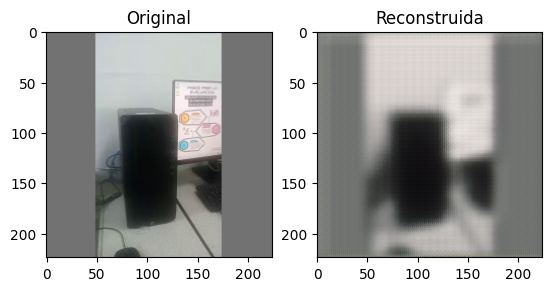

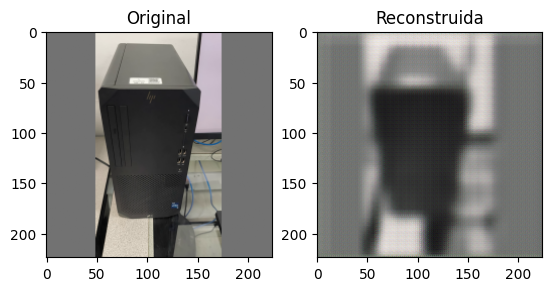

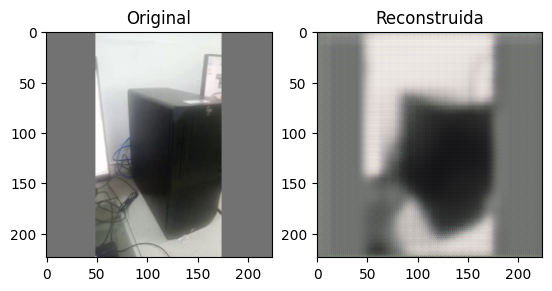

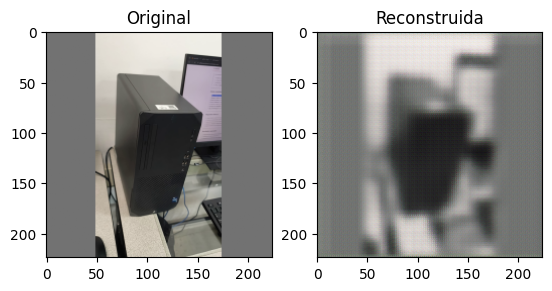

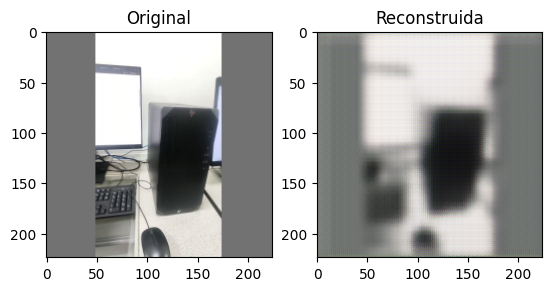

In [6]:
model.eval()
imgs = next(iter(loader))
imgs = imgs[:5].to(device)
recon = model(imgs).detach().cpu()

for i in range(5):
    orig = imgs[i].cpu().permute(1,2,0).numpy()
    rec  = recon[i].permute(1,2,0).numpy()
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(orig); ax[0].set_title("Original")
    ax[1].imshow(rec); ax[1].set_title("Reconstruida")
    plt.show()

In [7]:
#espacio latente 

In [8]:
# Supone que model = Autoencoder() ya está entrenado
model.eval()

# Toma un lote de imágenes
imgs = next(iter(loader))
imgs = imgs.to(device)

# Paso solo por el encoder
with torch.no_grad():
    z = model.encoder(imgs)

print("Forma de z:", z.shape)
#32 imágenes (batch).
#128 mapas de activación de tamaño 16×16 cada uno.

Forma de z: torch.Size([32, 128, 28, 28])


In [9]:
z_flat = z.view(z.size(0), -1).cpu().numpy()
print("Forma vectorizada:", z_flat.shape)

Forma vectorizada: (32, 100352)


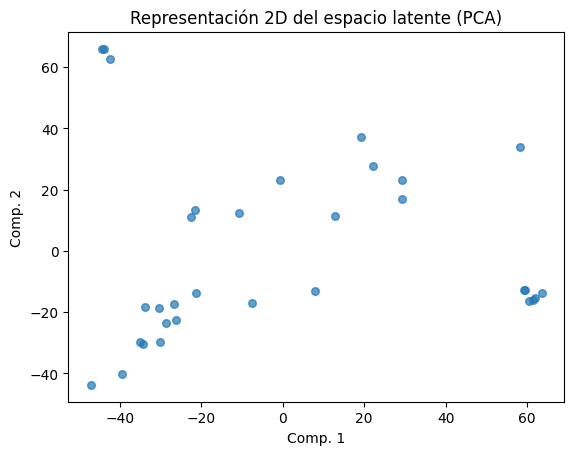

In [10]:
# reducción de dimensionalidad
z_pca = PCA(n_components=2).fit_transform(z_flat)
# o: z_tsne = TSNE(n_components=2, perplexity=30).fit_transform(z_flat)

plt.scatter(z_pca[:,0], z_pca[:,1], s=30, alpha=0.7)
plt.title("Representación 2D del espacio latente (PCA)")
plt.xlabel("Comp. 1")
plt.ylabel("Comp. 2")
plt.show()

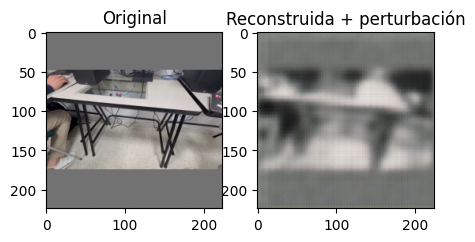

In [11]:
# Tomamos una imagen y su z
x = imgs[0:1]
with torch.no_grad():
    z = model.encoder(x)

# Pequeña perturbación del vector latente
delta = torch.randn_like(z) * 0.1
x_mod = model.decoder(z + delta)

# Mostrar original, reconstruida y perturbada
def show_pair(a, b, title_a, title_b):
    fig, ax = plt.subplots(1,2, figsize=(5,3))
    ax[0].imshow(a); ax[0].set_title(title_a)
    ax[1].imshow(b); ax[1].set_title(title_b)
    plt.show()

a = x[0].detach().cpu().permute(1,2,0).numpy()
b = x_mod[0].detach().cpu().permute(1,2,0).numpy()
show_pair(a, b, "Original", "Reconstruida + perturbación")

In [12]:
# super clasificador 

In [13]:
class LabeledImageDataset(Dataset):
    def __init__(self, root, size=224):
        self.size = size
        self.samples = []
        self.classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        for c in self.classes:
            for p in glob.glob(os.path.join(root, c, "*.png")):
                self.samples.append((p, self.class_to_idx[c]))

    def letterbox(self, img):
        h, w = img.shape[:2]
        s = self.size / max(h, w)
        nh, nw = int(h*s), int(w*s)
        r = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
        out = np.full((self.size, self.size, 3), 114, dtype=np.uint8)
        y0 = (self.size - nh)//2; x0 = (self.size - nw)//2
        out[y0:y0+nh, x0:x0+nw] = r
        return out

    def __len__(self): return len(self.samples)

    def __getitem__(self, i):
        p, y = self.samples[i]
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(self.letterbox(img), cv2.COLOR_BGR2RGB)
        x = torch.tensor(img, dtype=torch.float32).permute(2,0,1)/255.0
        return x, torch.tensor(y, dtype=torch.long)

In [14]:
ds = LabeledImageDataset("objetos_salon/processed", size=224)
n_classes = len(ds.classes)
loader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=2)

encoder = model.encoder.eval()            # usa tu autoencoder entrenado
for p in encoder.parameters(): p.requires_grad = False
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)

In [15]:
# modo A

In [16]:
# Extraer features (flatten de z)
X, Y = [], []
with torch.no_grad():
    for x, y in loader:
        z = encoder(x.to(device))                 # [B, C, H, W]
        z = torch.nn.functional.adaptive_avg_pool2d(z, 1)  # GAP -> [B,C,1,1]
        z = z.view(z.size(0), -1).cpu().numpy()   # [B, C]
        X.append(z); Y.append(y.numpy())
X = np.concatenate(X, axis=0); Y = np.concatenate(Y, axis=0)

Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
clf = LogisticRegression(max_iter=2000).fit(Xtr, Ytr)
pred = clf.predict(Xte)
print("Acc:", accuracy_score(Yte, pred))
print(classification_report(Yte, pred, target_names=ds.classes))

Acc: 0.3359375
              precision    recall  f1-score   support

         cpu       0.00      0.00      0.00        35
        mesa       0.27      0.48      0.34        42
       mouse       0.21      0.24      0.23        38
        nada       0.00      0.00      0.00        24
    pantalla       0.38      0.30      0.33        37
       silla       0.35      0.60      0.44        42
     teclado       0.54      0.55      0.55        38

    accuracy                           0.34       256
   macro avg       0.25      0.31      0.27       256
weighted avg       0.27      0.34      0.29       256



/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# modo B

In [18]:

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),             # -> [B,C,1,1]
    nn.Flatten(),                        # -> [B,C]
    nn.Linear(128, n_classes)            # ajusta "128" a canales de tu encoder
).to(device)

crit = nn.CrossEntropyLoss()
opt = optim.Adam(head.parameters(), lr=1e-3)

for epoch in range(20):
    head.train(); tot=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            z = encoder(x)
        logits = head(z)
        loss = crit(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*x.size(0)
    print(f"epoch {epoch+1} loss {tot/len(ds):.4f}")

epoch 1 loss 1.9557
epoch 2 loss 1.9217
epoch 3 loss 1.9159
epoch 4 loss 1.9093
epoch 5 loss 1.9033
epoch 6 loss 1.8989
epoch 7 loss 1.8954
epoch 8 loss 1.8921
epoch 9 loss 1.8875
epoch 10 loss 1.8857
epoch 11 loss 1.8821
epoch 12 loss 1.8777
epoch 13 loss 1.8757
epoch 14 loss 1.8731
epoch 15 loss 1.8708
epoch 16 loss 1.8684
epoch 17 loss 1.8690
epoch 18 loss 1.8657
epoch 19 loss 1.8657
epoch 20 loss 1.8630


In [19]:
# modo C

In [20]:
for name, p in encoder.named_parameters():
    p.requires_grad = name.startswith("2.")  # ejemplo: sólo último bloque
opt = optim.Adam(list(filter(lambda t: t.requires_grad, encoder.parameters())) + list(head.parameters()), lr=1e-4)

In [21]:
for epoch in range(20):
    head.train(); tot=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            z = encoder(x)
        logits = head(z)
        loss = crit(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*x.size(0)
    print(f"epoch {epoch+1} loss {tot/len(ds):.4f}")

epoch 1 loss 1.8602
epoch 2 loss 1.8596
epoch 3 loss 1.8592
epoch 4 loss 1.8590
epoch 5 loss 1.8588
epoch 6 loss 1.8588
epoch 7 loss 1.8587
epoch 8 loss 1.8585
epoch 9 loss 1.8584
epoch 10 loss 1.8580
epoch 11 loss 1.8580
epoch 12 loss 1.8579
epoch 13 loss 1.8580
epoch 14 loss 1.8575
epoch 15 loss 1.8576
epoch 16 loss 1.8573
epoch 17 loss 1.8572
epoch 18 loss 1.8573
epoch 19 loss 1.8569
epoch 20 loss 1.8569


In [22]:
# experimento con diferentes tamaños de cuello

In [45]:
class AutoencoderK(nn.Module):
    def __init__(self, k=128):
        super().__init__()
        self.enc_base = nn.Sequential(
            nn.Conv2d(3,32,3,2,1), nn.ReLU(),
            nn.Conv2d(32,64,3,2,1), nn.ReLU(),
            nn.Conv2d(64,128,3,2,1), nn.ReLU(),
        )
        self.enc_neck = nn.Sequential(
            nn.Conv2d(128, k, 1, bias=False),
            nn.BatchNorm2d(k),
            nn.ReLU(inplace=True)           # activa y re-introduce sparsity útil
        )
        self.dec_neck = nn.Conv2d(k,128,1)  # sin activación aquí
        self.dec_base = nn.Sequential(
            nn.ConvTranspose2d(128,64,4,2,1), nn.ReLU(),
            nn.ConvTranspose2d(64,32,4,2,1),  nn.ReLU(),
            nn.ConvTranspose2d(32,3,4,2,1),   nn.Sigmoid()
        )
    def encode(self,x):  return self.enc_neck(self.enc_base(x))
    def decode(self,z):  return self.dec_base(self.dec_neck(z))
    def forward(self,x): z=self.encode(x); return self.decode(z), z

In [50]:
def train_ae(model, loader, device, epochs=10, lr=1e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    for ep in range(epochs):
        model.train(); tot = 0
        for batch in loader:
            x = batch if isinstance(batch, torch.Tensor) else batch[0]
            x = x.to(device)
            opt.zero_grad()
            xhat, _ = model(x)
            loss = F.mse_loss(xhat, x)
            loss.backward(); opt.step()
            tot += loss.item() * x.size(0)
        print(f"época {ep+1:02d}  MSE {tot/len(loader.dataset):.6f}")

In [51]:
def eval_recon(model, loader, device, batches=5):
    model.eval(); mse_sum=0; n=0
    with torch.no_grad():
        for i, batch in enumerate(loader):
            x = batch if isinstance(batch, torch.Tensor) else batch[0]
            x = x.to(device)
            xhat, _ = model(x)
            mse = F.mse_loss(xhat, x).item()
            mse_sum += mse; n += 1
            if i+1 >= batches: break
    mse = mse_sum/n
    psnr = 10*math.log10(1.0/mse)
    return mse, psnr

In [48]:
def linear_probe(model, loader, device, class_names):
    X, Y = [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, z = model(x)                                  # [B,k,16,16]
            z = F.adaptive_avg_pool2d(z, 1).view(z.size(0), -1).cpu().numpy()
            X.append(z); Y.append(y.numpy())
    X = np.concatenate(X); Y = np.concatenate(Y)
    Xtr, Xte, Ytr, Yte = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
    clf = LogisticRegression(max_iter=2000).fit(Xtr, Ytr)
    acc = accuracy_score(Yte, clf.predict(Xte))
    return acc

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
k = 128
model = AutoencoderK(k=k)

# Entrenamiento (10 épocas sugeridas)
train_ae(model, loader, device, epochs=10, lr=1e-3)

# Reconstrucción: MSE y PSNR
mse, psnr = eval_recon(model, loader, device, batches=8)
print(f"MSE recon: {mse:.6f}   PSNR: {psnr:.2f} dB")

época 01  MSE 0.020479
época 02  MSE 0.006530
época 03  MSE 0.005157
época 04  MSE 0.004327
época 05  MSE 0.003720
época 06  MSE 0.003395
época 07  MSE 0.003007
época 08  MSE 0.002730
época 09  MSE 0.002522
época 10  MSE 0.002247
MSE recon: 0.003825   PSNR: 24.17 dB


In [57]:
acc = linear_probe(model, loader, device, class_names=getattr(ds, "classes", None))
print(f"Linear probe (k=128) accuracy: {acc:.4f}")

Linear probe (k=128) accuracy: 0.7344


In [53]:
import torch, torch.nn.functional as F
import numpy as np

def inspect_latent(model, loader, device, batches=3):
    model.eval()
    shapes, means, stds, zeros = [], [], [], []
    with torch.no_grad():
        for i,(x,*_) in enumerate(loader):
            x = x.to(device) if isinstance(x, torch.Tensor) else x[0].to(device)
            _, z = model(x)                      # [B,k,28,28] para input 224
            shapes.append(z.shape)
            zc = z.view(z.size(0), -1)
            means.append(zc.mean(dim=1).cpu().numpy())
            stds.append(zc.std(dim=1).cpu().numpy())
            zeros.append((zc==0).float().mean(dim=1).cpu().numpy())  # ReLU sparsity
            if i+1>=batches: break
    print("shape ejemplos:", shapes[:2])
    print("mean z  (promedio):", float(np.concatenate(means).mean()))
    print("std z   (promedio):", float(np.concatenate(stds).mean()))
    print("sparsity (fracción de ceros):", float(np.concatenate(zeros).mean()))

# uso:
inspect_latent(model, loader, device)

shape ejemplos: [torch.Size([64, 128, 28, 28]), torch.Size([64, 128, 28, 28])]
mean z  (promedio): 0.4541482627391815
std z   (promedio): 0.7018168568611145
sparsity (fracción de ceros): 0.4692360460758209


In [54]:
def latent_size(k, h_in=224, downs=3):
    h = h_in // (2**downs)
    return k*h*h, h

# ejemplo:
n_params, h = latent_size(k=64)  # devuelve 64*28*28, 28
print("n elem en z:", n_params, "mapa:", f"{64}x{h}x{h}")

n elem en z: 50176 mapa: 64x28x28


In [55]:
# para k= 128

In [56]:
def inspect_latent(model, loader, device, batches=3):
    model.eval()
    shapes, means, stds, zeros = [], [], [], []
    with torch.no_grad():
        for i, batch in enumerate(loader):
            x = batch if isinstance(batch, torch.Tensor) else batch[0]
            x = x.to(device)
            _, z = model(x)                          # [B,k,28,28] si input=224
            shapes.append(tuple(z.shape))
            zc = z.view(z.size(0), -1)
            means.append(zc.mean(dim=1).cpu().numpy())                 # por muestra
            stds.append(zc.std(dim=1).cpu().numpy())
            zeros.append((zc==0).float().mean(dim=1).cpu().numpy())    # sparsity
            if i+1 >= batches: break

    means = np.concatenate(means); stds = np.concatenate(stds); zeros = np.concatenate(zeros)
    print("shapes (ejemplos):", shapes[:2])
    print(f"mean(z) promedio: {means.mean():.6f}")
    print(f"std(z)  promedio: {stds.mean():.6f}")
    print(f"sparsity promedio (fracción de ceros): {zeros.mean():.6f}")

# Uso:
# inspect_latent(model, loader_ae, device)
inspect_latent(model, loader, device)

shapes (ejemplos): [(64, 128, 28, 28), (64, 128, 28, 28)]
mean(z) promedio: 0.461179
std(z)  promedio: 0.707961
sparsity promedio (fracción de ceros): 0.468458
